<a href="https://colab.research.google.com/github/hahe050305/MICRO-TREND/blob/main/MFG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import torch
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.sparse.linalg import svds
from sklearn.preprocessing import LabelEncoder

df = pd.read_excel('enhanced_ecommerce.xlsx')

# Preview the dataset
print("Dataset Head:")
print(df.head())


Dataset Head:
  User_ID Product_ID   Price  Discount_Offered           Purchase_Time  \
0   U0103      P0462  165.52                 0 2024-10-21 19:30:22.000   
1   U0436      P0120  117.96                20 2024-11-06 04:40:21.425   
2   U0861      P0382  262.50                10 2024-11-19 04:01:17.425   
3   U0271      P0055   60.16                 5 2024-11-27 03:19:53.425   
4   U0107      P0027  378.37                 0 2024-11-19 00:38:37.425   

   Browsing_History  Abandoned_Cart Customer_Segment  Conversion  Age  ...  \
0                 7               1            Loyal           0   21  ...   
1                 7               0              New           1   59  ...   
2                 1               0       Occasional           0   60  ...   
3                 8               0              New           1   46  ...   
4                 1               0            Loyal           1   58  ...   

  Pages_Viewed Last_Browsed_Category       Occasion Discount_Type  \
0  

In [ ]:
# Map users and products to unique IDs
df['user_id'] = df['User_ID'].astype('category').cat.codes
df['product_id'] = df['Product_ID'].astype('category').cat.codes

# Create user-product interaction matrix
interaction_matrix = df.pivot_table(index='user_id', columns='product_id', values='Price', aggfunc='mean').fillna(0)
interaction_matrix = interaction_matrix.to_numpy()

# Train-test split

from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(interaction_matrix, test_size=0.2, random_state=42)

print(f"Train Data Shape: {train_data.shape}")
print(f"Test Data Shape: {test_data.shape}")

ValueError: y contains previously unseen labels: [5, 107, 147, 208, 295, 326, 418, 473, 478, 577, 672, 703, 708, 851, 858, 967]

In [ ]:
# Function to perform matrix factorization
def matrix_factorization(train_data, k=10):
    u, sigma, vt = svds(train_data, k=k)
    sigma = np.diag(sigma)
    predicted_matrix = np.dot(np.dot(u, sigma), vt)
    return predicted_matrix

from sklearn.model_selection import train_test_split
predicted_train = matrix_factorization(train_data)

# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(train_data[train_data > 0], predicted_train[train_data > 0]))
print(f"Training RMSE: {train_rmse}")


NameError: name 'svds' is not defined

In [ ]:
# Discount allocation based on predicted scores
def assign_discounts(predicted_scores, threshold_high=0.8, threshold_mid=0.5):
    discounts = np.zeros_like(predicted_scores)
    discounts[predicted_scores > threshold_high] = 0.10  # 10% for high scores
    discounts[(predicted_scores > threshold_mid) & (predicted_scores <= threshold_high)] = 0.20  # 20% for mid scores
    discounts[predicted_scores <= threshold_mid] = 0.50  # 50% for low scores
    return discounts

# Apply discounts to predicted interaction matrix
discount_matrix = assign_discounts(predicted_train)

# Print a sample of discounts
print("Discount Matrix (Sample):")
print(discount_matrix[:5, :5])

Discount Matrix (Sample):
[[0.5 0.1 0.1 0.5 0.2]
 [0.5 0.5 0.5 0.5 0.5]
 [0.2 0.5 0.2 0.5 0.5]
 [0.1 0.5 0.2 0.5 0.5]
 [0.1 0.5 0.5 0.5 0.2]]


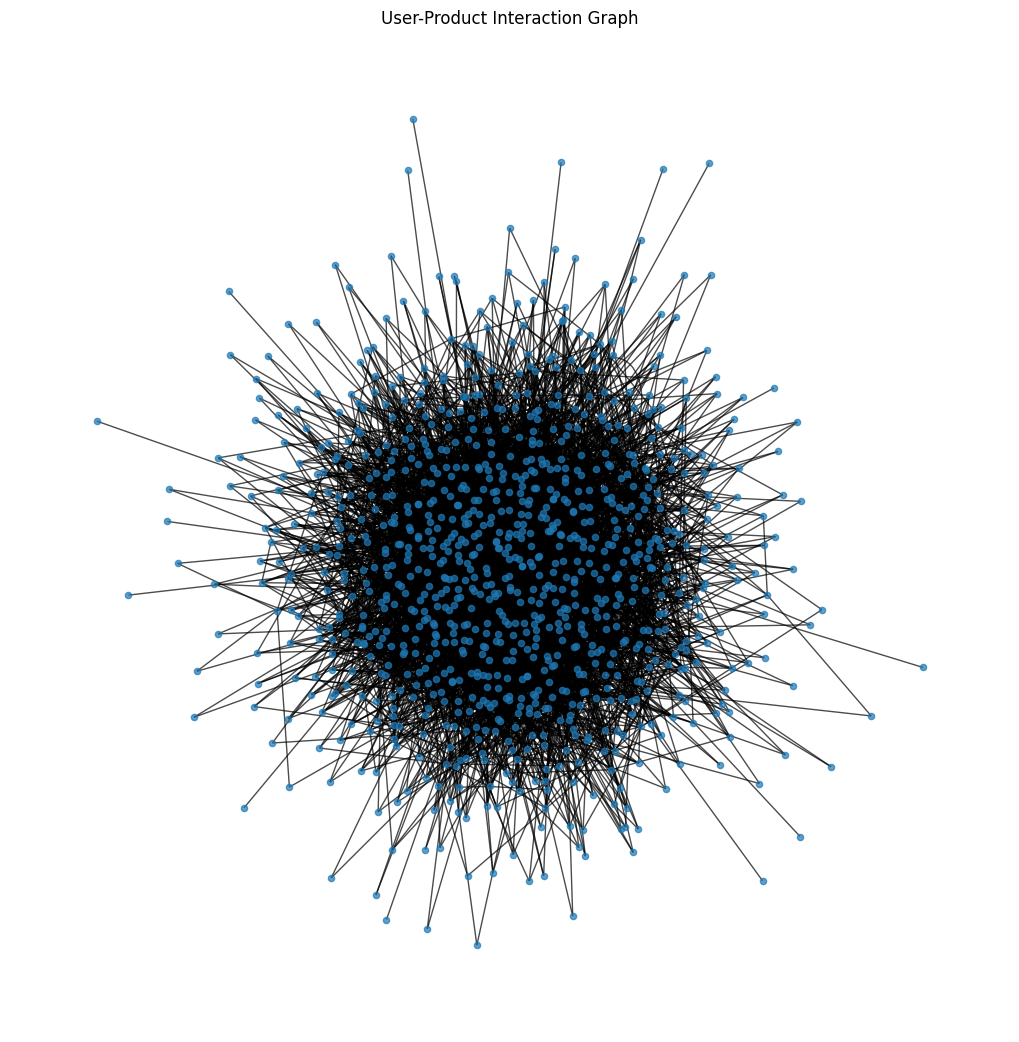

In [ ]:
# Create a graph using NetworkX
graph = nx.Graph()

# Add nodes for users and products
graph.add_nodes_from(df['user_id'], bipartite=0)
graph.add_nodes_from(df['product_id'], bipartite=1)

# Add edges (user-product interactions)
edges = list(zip(df['user_id'], df['product_id']))
graph.add_edges_from(edges)

# Visualize the graph
plt.figure(figsize=(10, 10))
nx.draw(graph, node_size=20, alpha=0.7)
plt.title("User-Product Interaction Graph")
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

df = pd.read_excel('enhanced_ecommerce.xlsx')

product_to_brand_map = df.set_index('Product_ID')['Brand_Name'].to_dict()

product_encoder = LabelEncoder()
user_encoder = LabelEncoder()
product_encoder.fit(df['Product_ID'])
user_encoder.fit(df['User_ID'])

predicted_train = np.random.rand(len(user_encoder.classes_), len(product_encoder.classes_))
discount_matrix = np.random.rand(len(user_encoder.classes_), len(product_encoder.classes_)) * 50  # Discounts in percentage

def generate_recommendations(predicted_scores, discount_matrix, top_n=5, product_encoder=product_encoder, user_encoder=user_encoder):
    product_map = dict(enumerate(product_encoder.classes_))
    user_map = dict(enumerate(user_encoder.classes_))

    recommendations = {}
    for user_id in range(predicted_scores.shape[0]):
        top_products = np.argsort(-predicted_scores[user_id])[:top_n]

        recommended_product_names = [product_to_brand_map[product_map[i]] for i in top_products]

        recommendations[user_map[user_id]] = {
            "Recommended Products": recommended_product_names,
            "Discounts": discount_matrix[user_id, top_products],
        }
    return recommendations

recommendations = generate_recommendations(predicted_train, discount_matrix, top_n=5)

for user_id in list(recommendations.keys())[:5]:
    print(f"User {user_id}:")
    print(f"  Recommended Products (Brand Names): {recommendations[user_id]['Recommended Products']}")
    print(f"  Discounts: {recommendations[user_id]['Discounts']}")


User U0001:
  Recommended Products (Brand Names): ['Bloomsbury', 'Zebronics', 'Generic Brand', 'Maybelline', 'Philips']
  Discounts: [46.51325694 32.62206738 38.9176138  49.36870283  9.68429956]
User U0002:
  Recommended Products (Brand Names): ['Philips', 'Pigeon', 'HarperCollins', 'Hawkins', 'Zebronics']
  Discounts: [49.06408231 32.54509148 11.82699395 48.04793489 27.35581327]
User U0003:
  Recommended Products (Brand Names): ['Adidas', 'Nike', 'Generic Brand', 'Van Heusen', 'Pigeon']
  Discounts: [18.90026163 40.8496866  13.49283483 48.91675113 44.02620185]
User U0004:
  Recommended Products (Brand Names): ['Adidas', 'Prestige', 'Generic Brand', 'Generic Brand', 'Van Heusen']
  Discounts: [42.59451384 34.5379315   5.78197748 29.5979541  40.49219574]
User U0005:
  Recommended Products (Brand Names): ['Van Heusen', 'Louis Philippe', 'Van Heusen', 'Generic Brand', 'Generic Brand']
  Discounts: [29.8346025  16.20248703  7.70235953 22.8294675  22.78316432]


In [ ]:
import pandas as pd
df = pd.read_excel('enhanced_ecommerce.xlsx')

train_data = df.sample(frac=0.8, random_state=42)
test_data = df.drop(train_data.index)

Precision@5: 0.00
Recall@5: 0.00


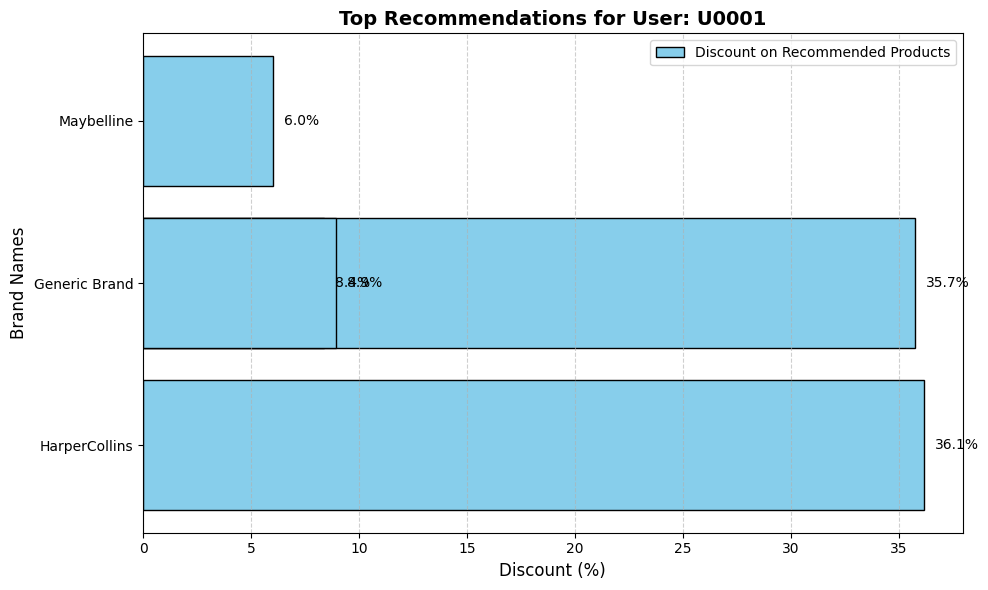

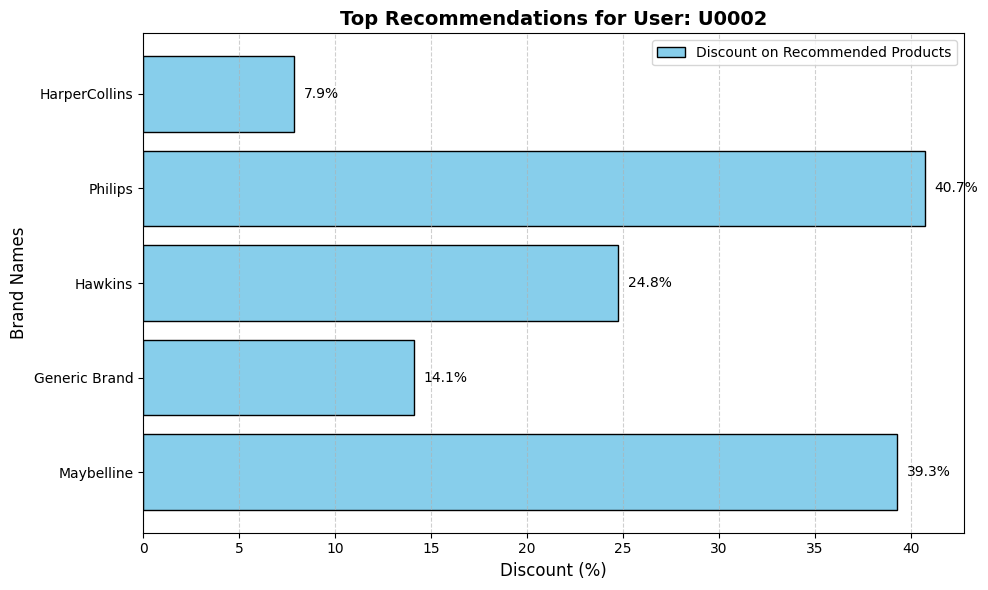

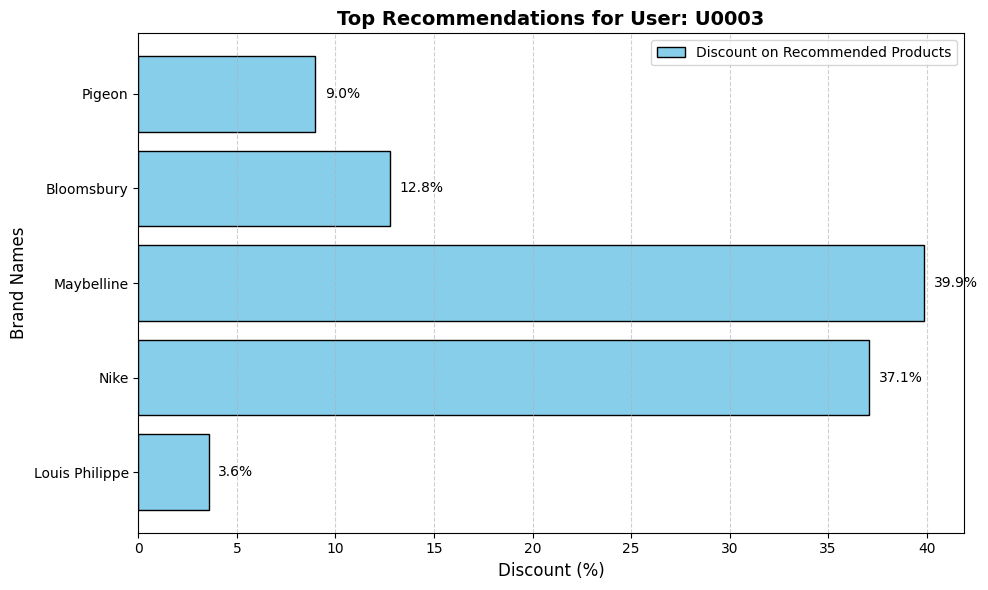

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Load data
df = pd.read_excel('enhanced_ecommerce.xlsx')

# Create a mapping from Product_ID to Brand_Name
product_to_brand_map = df.set_index('Product_ID')['Brand_Name'].to_dict()

# Encode product and user IDs
product_encoder = LabelEncoder()
user_encoder = LabelEncoder()
product_encoder.fit(df['Product_ID'])
user_encoder.fit(df['User_ID'])

# Simulate predicted scores and discount matrix
predicted_train = np.random.rand(len(user_encoder.classes_), len(product_encoder.classes_))
discount_matrix = np.random.rand(len(user_encoder.classes_), len(product_encoder.classes_)) * 50  # Discounts in percentage

# Generate Recommendations
def generate_recommendations(predicted_scores, discount_matrix, top_n=5, product_encoder=product_encoder, user_encoder=user_encoder):
    """
    Generates recommendations with product names and discounts for each user.

    Parameters:
    - predicted_scores: Array of predicted scores for user-product pairs.
    - discount_matrix: Array of discount values corresponding to user-product pairs.
    - top_n: Number of top recommendations to generate.
    - product_encoder: Encoder for products.
    - user_encoder: Encoder for users.

    Returns:
    - recommendations: A dictionary containing recommendations and discounts for each user.
    """
    # Create mappings from encoded indices to original values
    product_map = dict(enumerate(product_encoder.classes_))
    user_map = dict(enumerate(user_encoder.classes_))

    recommendations = {}
    for user_id in range(predicted_scores.shape[0]):
        # Get the top N product indices for this user
        top_products = np.argsort(-predicted_scores[user_id])[:top_n]

        # Map indices to actual product names (using Brand_Names)
        recommended_product_names = [product_to_brand_map[product_map[i]] for i in top_products]

        # Store recommendations and discounts
        recommendations[user_map[user_id]] = {
            "Recommended Products": recommended_product_names,
            "Discounts": discount_matrix[user_id, top_products],
        }
    return recommendations

# Simulate a test data DataFrame for evaluation
test_data = df.sample(frac=0.2, random_state=42)  # Use a random subset of the data for testing

# Generate recommendations
recommendations = generate_recommendations(predicted_train, discount_matrix, top_n=5)

# Evaluate Recommendations
def evaluate_recommendations(recommendations, test_data, top_n=5):
    """
    Evaluates the precision and recall of recommendations.

    Parameters:
    - recommendations (dict): Recommendations dictionary with user IDs as keys.
    - test_data (DataFrame): Test data containing actual user-product interactions.
    - top_n (int): Number of recommendations to consider.

    Returns:
    - avg_precision (float): Average precision across users.
    - avg_recall (float): Average recall across users.
    """
    # Initialize precision and recall scores
    precision_scores = []
    recall_scores = []

    # Iterate over each user in the test data
    for user_id in test_data['User_ID'].unique():
        # Get the recommended products for the user
        if user_id in recommendations:
            recommended_products = recommendations[user_id]['Recommended Products']
        else:
            continue  # Skip if user does not have recommendations

        # Get the actual interacted products for the user from the test data
        actual_interactions = test_data[test_data['User_ID'] == user_id]['Product_ID'].values

        # Calculate precision@N (number of relevant items in the top N recommendations)
        relevant_recommendations = set(recommended_products).intersection(actual_interactions)
        precision_at_n = len(relevant_recommendations) / top_n

        # Calculate recall@N (number of actual interacted products in the top N recommendations)
        recall_at_n = len(relevant_recommendations) / len(actual_interactions)

        # Store the precision and recall for this user
        precision_scores.append(precision_at_n)
        recall_scores.append(recall_at_n)

    # Calculate average precision and recall
    avg_precision = np.mean(precision_scores)
    avg_recall = np.mean(recall_scores)

    return avg_precision, avg_recall

# Run evaluation
precision, recall = evaluate_recommendations(recommendations, test_data, top_n=5)
print(f"Precision@5: {precision:.2f}")
print(f"Recall@5: {recall:.2f}")

# Visualize Recommendations
def visualize_recommendations(recommendations, num_users=3):
    """
    Visualizes recommendations for the given number of users.

    Parameters:
    - recommendations (dict): The recommendations dictionary with user IDs as keys.
    - num_users (int): Number of users to visualize.
    """
    selected_users = list(recommendations.keys())[:num_users]

    for user_id in selected_users:
        # Extract data for this user
        products = recommendations[user_id]['Recommended Products']
        discounts = recommendations[user_id]['Discounts']

        # Create a horizontal bar chart
        plt.figure(figsize=(10, 6))
        bars = plt.barh(products, discounts, color='skyblue', edgecolor='black')

        # Add annotations to each bar (discount values)
        for bar, discount in zip(bars, discounts):
            plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height() / 2,
                     f"{discount:.1f}%", va='center', fontsize=10)

        # Add labels, title, grid, and legend
        plt.xlabel("Discount (%)", fontsize=12)
        plt.ylabel("Brand Names", fontsize=12)
        plt.title(f"Top Recommendations for User: {user_id}", fontsize=14, weight='bold')
        plt.gca().invert_yaxis()  # Invert y-axis for better readability
        plt.grid(axis='x', linestyle='--', alpha=0.6)

        # Add a legend to indicate what the bars represent
        plt.legend(["Discount on Recommended Products"], loc='upper right', fontsize=10)

        # Adjust layout and show plot
        plt.tight_layout()
        plt.show()

# Visualize recommendations for 3 users
visualize_recommendations(recommendations, num_users=3)

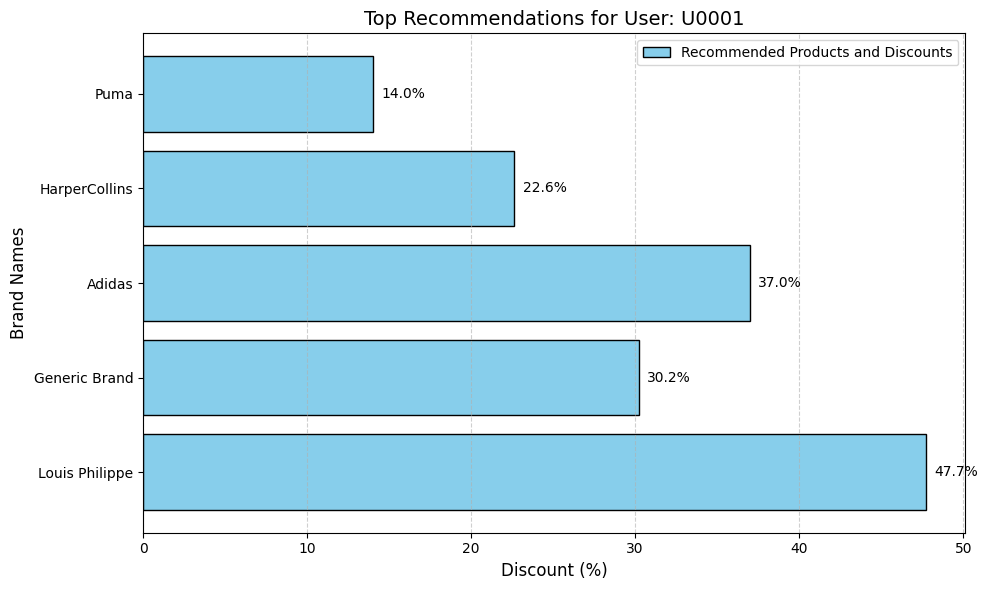

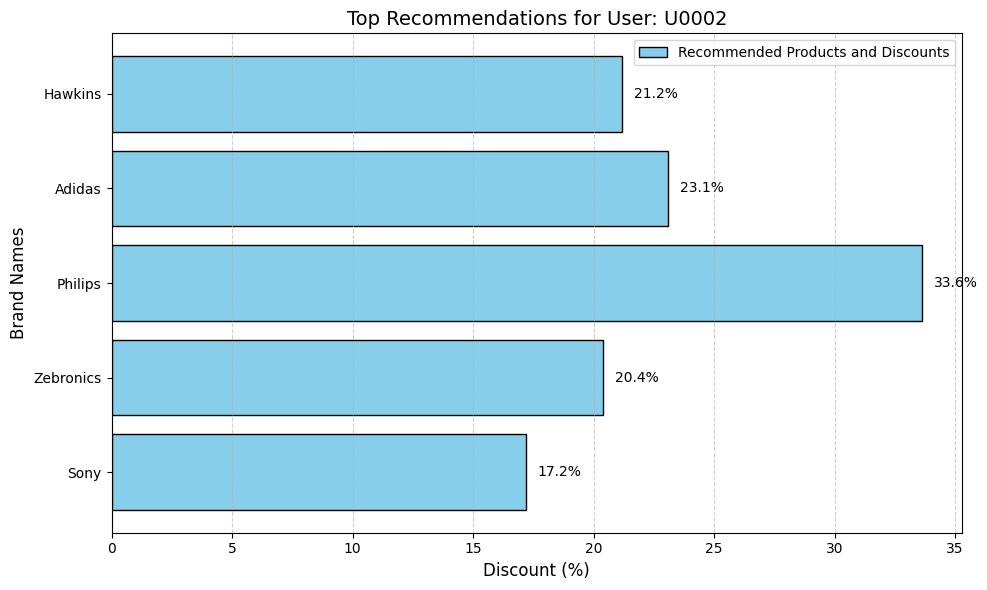

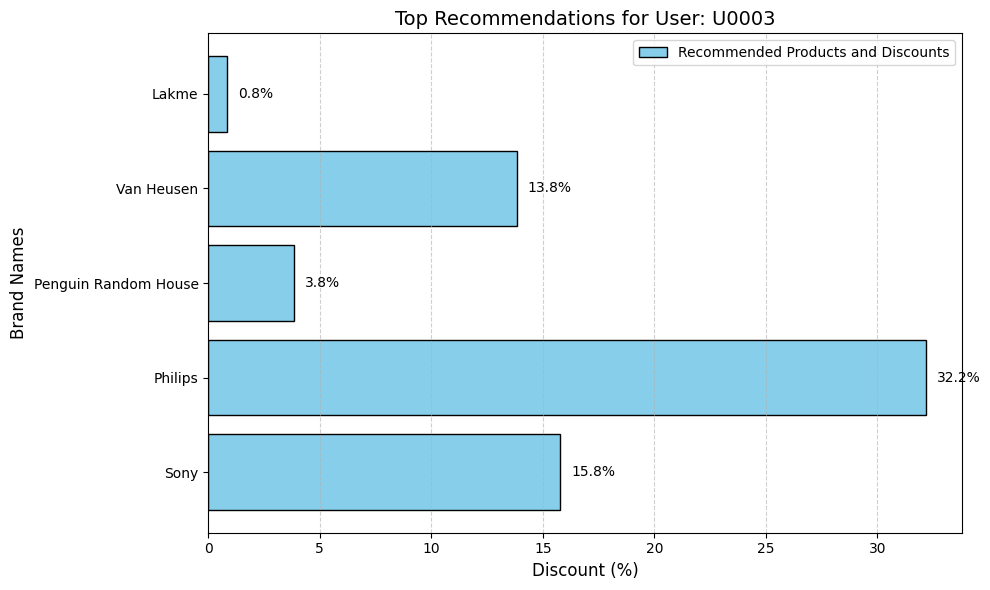

In [ ]:
import matplotlib.pyplot as plt

# Function to visualize recommendations
def visualize_recommendations(recommendations, num_users=3):
    """
    Visualizes recommendations for the given number of users.

    Parameters:
    - recommendations (dict): The recommendations dictionary with user IDs as keys.
    - num_users (int): Number of users to visualize.
    """
    selected_users = list(recommendations.keys())[:num_users]

    for user_id in selected_users:
        # Extract data for this user
        products = recommendations[user_id]['Recommended Products']
        discounts = recommendations[user_id]['Discounts']

        # Create a horizontal bar chart
        plt.figure(figsize=(10, 6))
        bars = plt.barh(products, discounts, color='skyblue', edgecolor='black')

        # Add annotations to each bar (discount values)
        for bar, discount in zip(bars, discounts):
            plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
                     f"{discount:.1f}%", va='center', fontsize=10)

        # Labels, title, and legend
        plt.xlabel("Discount (%)", fontsize=12)
        plt.ylabel("Brand Names", fontsize=12)
        plt.title(f"Top Recommendations for User: {user_id}", fontsize=14)
        plt.gca().invert_yaxis()  # Invert y-axis for better readability
        plt.grid(axis='x', linestyle='--', alpha=0.6)

        # Add a legend to indicate what the bars represent
        plt.legend(["Recommended Products and Discounts"], loc='upper right', fontsize=10)

        # Adjust layout and show plot
        plt.tight_layout()
        plt.show()

# Visualize recommendations for 3 users
visualize_recommendations(recommendations, num_users=3)


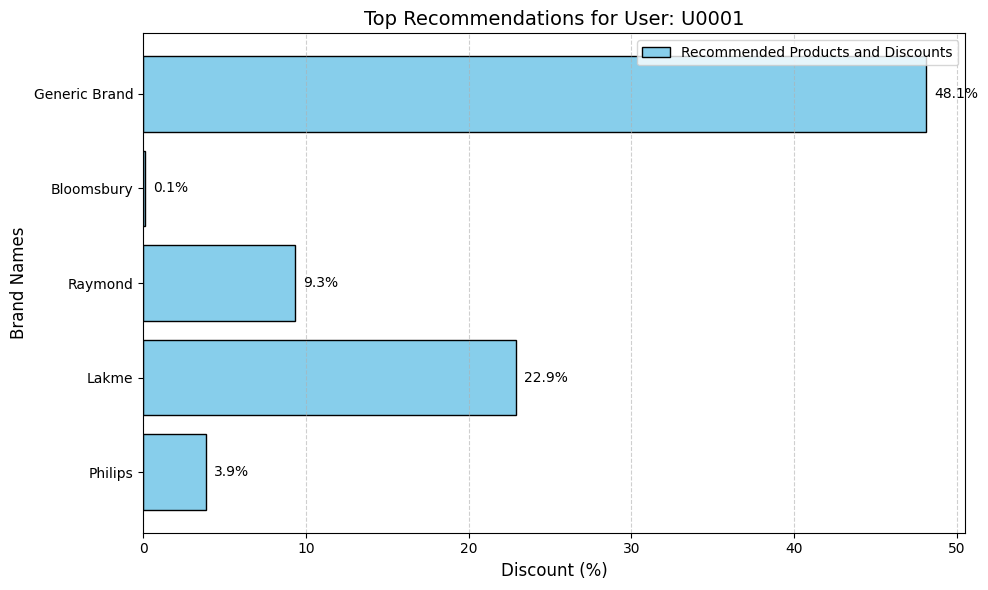

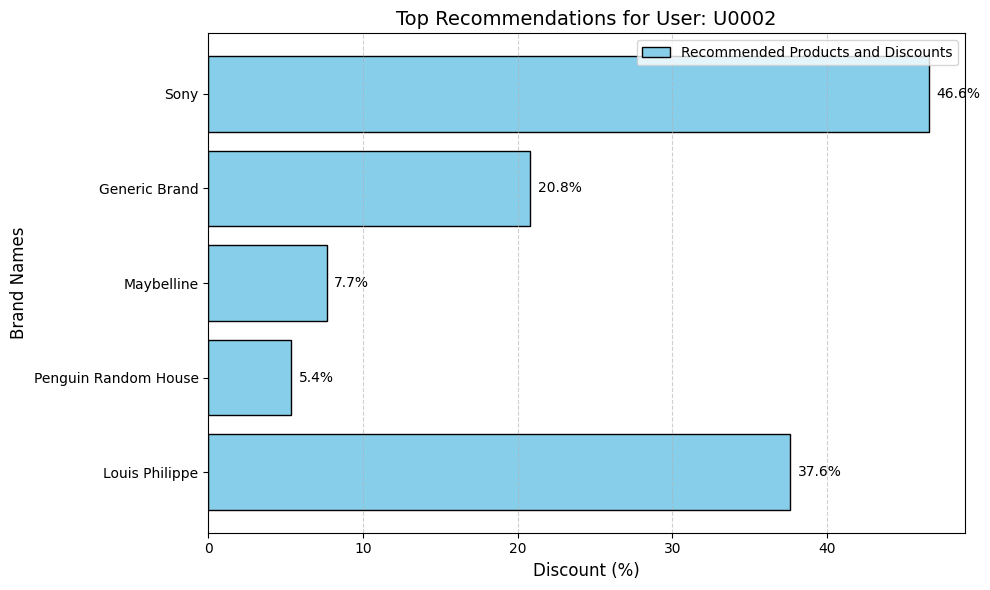

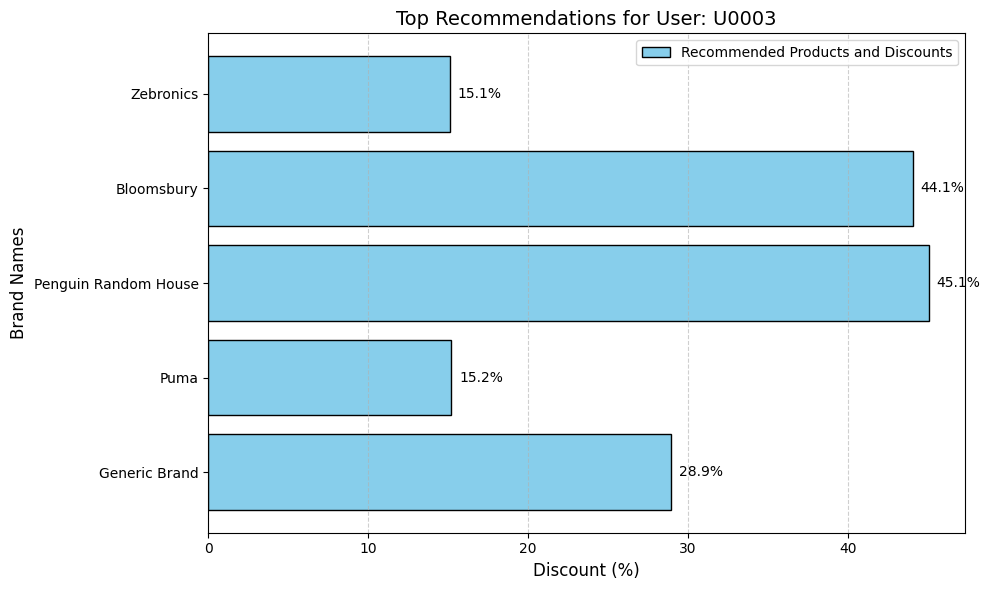

ValueError: y contains previously unseen labels: 386

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Load data
df = pd.read_excel('enhanced_ecommerce.xlsx')

# Create a mapping from Product_ID to Brand_Name
product_to_brand_map = df.set_index('Product_ID')['Brand_Name'].to_dict()

# Encode Product_ID and User_ID
product_encoder = LabelEncoder()
user_encoder = LabelEncoder()
df['Product_ID'] = product_encoder.fit_transform(df['Product_ID'])
df['User_ID'] = user_encoder.fit_transform(df['User_ID'])

# Split the data into train and test sets
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

# Simulate predicted scores and discount matrix (for demonstration purposes)
predicted_train = np.random.rand(len(user_encoder.classes_), len(product_encoder.classes_))
discount_matrix = np.random.rand(len(user_encoder.classes_), len(product_encoder.classes_)) * 50  # Discounts in percentage

# Recommendation generation function
def generate_recommendations(predicted_scores, discount_matrix, top_n=5):
    product_map = dict(enumerate(product_encoder.classes_))
    user_map = dict(enumerate(user_encoder.classes_))

    recommendations = {}
    for user_id in range(predicted_scores.shape[0]):
        # Get the top N product indices for this user
        top_products = np.argsort(-predicted_scores[user_id])[:top_n]

        # Map indices to actual product names (using Brand_Names)
        recommended_product_names = [product_to_brand_map[product_map[i]] for i in top_products]

        # Store recommendations and discounts
        recommendations[user_map[user_id]] = {
            "Recommended Products": recommended_product_names,
            "Discounts": discount_matrix[user_id, top_products],
        }
    return recommendations

# Generate recommendations
recommendations = generate_recommendations(predicted_train, discount_matrix, top_n=5)

# Visualize recommendations
import matplotlib.pyplot as plt

def visualize_recommendations(recommendations, num_users=3):
    selected_users = list(recommendations.keys())[:num_users]

    for user_id in selected_users:
        # Extract data for this user
        products = recommendations[user_id]['Recommended Products']
        discounts = recommendations[user_id]['Discounts']

        # Create a horizontal bar chart
        plt.figure(figsize=(10, 6))
        bars = plt.barh(products, discounts, color='skyblue', edgecolor='black')

        # Add annotations to each bar
        for bar, discount in zip(bars, discounts):
            plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height() / 2,
                     f"{discount:.1f}%", va='center', fontsize=10)

        # Labels, title, and legend
        plt.xlabel("Discount (%)", fontsize=12)
        plt.ylabel("Brand Names", fontsize=12)
        plt.title(f"Top Recommendations for User: {user_id}", fontsize=14)
        plt.gca().invert_yaxis()  # Invert y-axis for better readability
        plt.grid(axis='x', linestyle='--', alpha=0.6)
        plt.legend(["Recommended Products and Discounts"], loc='upper right', fontsize=10)

        # Adjust layout and show plot
        plt.tight_layout()
        plt.show()

# Visualize recommendations for 3 users
visualize_recommendations(recommendations, num_users=3)

# Evaluate recommendations
def evaluate_recommendations(recommendations, test_data, top_n=5):
    precision_scores = []
    recall_scores = []

    # Ensure test data Product_ID is encoded
    test_data['Product_ID'] = product_encoder.transform(test_data['Product_ID'])

    for user_id in test_data['User_ID'].unique():
        if user_id in recommendations:
            # Get recommended products for the user
            recommended_products = recommendations[user_id]['Recommended Products']

            # Map recommended products to encoded Product_ID
            recommended_encoded = [product_encoder.transform([p])[0] for p in recommended_products]
        else:
            continue

        # Get actual interactions
        actual_interactions = test_data[test_data['User_ID'] == user_id]['Product_ID'].values
        relevant_recommendations = set(recommended_encoded).intersection(actual_interactions)

        # Calculate precision and recall
        precision_at_n = len(relevant_recommendations) / top_n
        recall_at_n = len(relevant_recommendations) / len(actual_interactions) if len(actual_interactions) > 0 else 0

        precision_scores.append(precision_at_n)
        recall_scores.append(recall_at_n)

    avg_precision = np.mean(precision_scores) if precision_scores else 0
    avg_recall = np.mean(recall_scores) if recall_scores else 0

    return avg_precision, avg_recall

# Evaluate recommendations
precision, recall = evaluate_recommendations(recommendations, test_data, top_n=5)
print(f"Precision@5: {precision:.2f}")
print(f"Recall@5: {recall:.2f}")


In [ ]:
import networkx as nx
print(nx.__version__)

3.4.2


In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from torch_geometric.utils import from_networkx
from torch_geometric.nn import GCNConv
import torch
import torch.nn as nn
from torch.optim import Adam

In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.7 MB/s eta 0:00:00


In [ ]:
# Load dataset
df = pd.read_excel('enhanced_ecommerce.xlsx')

# Display a preview
print(df.head())

# Example columns in the dataset:
# user_id, product_id, purchase_price, category, discount


  User_ID Product_ID   Price  Discount_Offered           Purchase_Time  \
0   U0103      P0462  165.52                 0 2024-10-21 19:30:22.000   
1   U0436      P0120  117.96                20 2024-11-06 04:40:21.425   
2   U0861      P0382  262.50                10 2024-11-19 04:01:17.425   
3   U0271      P0055   60.16                 5 2024-11-27 03:19:53.425   
4   U0107      P0027  378.37                 0 2024-11-19 00:38:37.425   

   Browsing_History  Abandoned_Cart Customer_Segment  Conversion  Age  ...  \
0                 7               1            Loyal           0   21  ...   
1                 7               0              New           1   59  ...   
2                 1               0       Occasional           0   60  ...   
3                 8               0              New           1   46  ...   
4                 1               0            Loyal           1   58  ...   

  Pages_Viewed Last_Browsed_Category       Occasion Discount_Type  \
0            4   

In [ ]:
# Normalize purchase price for scaling
df['purchase_price'] = (df['Price'] - df['Price'].min()) / (df['Price'].max() - df['Price'].min())

# Map user_id and product_id to indices
user_map = {user: idx for idx, user in enumerate(df['User_ID'].unique())}
product_map = {product: idx for idx, product in enumerate(df['Product_ID'].unique())}

df['user_idx'] = df['User_ID'].map(user_map)
df['product_idx'] = df['Product_ID'].map(product_map)

# Split the data into training and testing sets
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)


In [ ]:
# Create the user-product interaction matrix
num_users = len(user_map)
num_products = len(product_map)
interaction_matrix = np.zeros((num_users, num_products))

for _, row in train_data.iterrows():
    interaction_matrix[row['user_idx'], row['product_idx']] = row['purchase_price']

# Matrix Factorization
class MatrixFactorization:
    def __init__(self, R, K, alpha, beta, iterations):
        self.R = R
        self.num_users, self.num_items = R.shape
        self.K = K
        self.alpha = alpha  # Learning rate
        self.beta = beta    # Regularization parameter
        self.iterations = iterations

    def train(self):
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))
        self.b_u = np.zeros(self.num_users)
        self.b_i = np.zeros(self.num_items)
        self.b = np.mean(self.R[self.R > 0])

        for _ in range(self.iterations):
            for i in range(self.num_users):
                for j in range(self.num_items):
                    if self.R[i, j] > 0:
                        error = self.R[i, j] - self.predict(i, j)
                        self.P[i, :] += self.alpha * (error * self.Q[j, :] - self.beta * self.P[i, :])
                        self.Q[j, :] += self.alpha * (error * self.P[i, :] - self.beta * self.Q[j, :])
                        self.b_u[i] += self.alpha * (error - self.beta * self.b_u[i])
                        self.b_i[j] += self.alpha * (error - self.beta * self.b_i[j])

    def predict(self, i, j):
        return self.b + self.b_u[i] + self.b_i[j] + np.dot(self.P[i, :], self.Q[j, :])

# Train the model
mf = MatrixFactorization(interaction_matrix, K=10, alpha=0.01, beta=0.01, iterations=100)
mf.train()

# Predict the test set
predictions = []
for _, row in test_data.iterrows():
    pred = mf.predict(row['user_idx'], row['product_idx'])
    predictions.append(pred)

rmse = np.sqrt(mean_squared_error(test_data['purchase_price'], predictions))
print(f"Matrix Factorization RMSE: {rmse}")


Matrix Factorization RMSE: 0.3329399040897908


In [ ]:
# Add features for each node
for node_idx in graph.nodes():
    if node_idx in user_map.values():  # User nodes
        graph.nodes[node_idx]['type'] = 'user'
        graph.nodes[node_idx]['average_spent'] = train_data[train_data['user_idx'] == node_idx]['purchase_price'].mean()
        graph.nodes[node_idx]['Brand_Name'] = np.nan  # Not applicable for users
    else:  # Product nodes
        graph.nodes[node_idx]['type'] = 'product'
        graph.nodes[node_idx]['average_spent'] = np.nan  # Not applicable for products
        graph.nodes[node_idx]['Brand_Name'] = df[df['product_idx'] == node_idx]['Brand_Name'].iloc[0]

# Encode Brand_Name as numeric (if applicable)
brand_map = {brand: idx for idx, brand in enumerate(df['Brand_Name'].unique())}
for node_idx in graph.nodes():
    if graph.nodes[node_idx]['type'] == 'product':
        brand_name = graph.nodes[node_idx]['Brand_Name']
        graph.nodes[node_idx]['Brand_Name'] = brand_map[brand_name] if pd.notna(brand_name) else -1  # Encode or set as -1

# Convert to PyTorch Geometric format
data = from_networkx(graph)

# Prepare features for each node
features = []
for node_idx in graph.nodes():
    node_data = graph.nodes[node_idx]
    feature_vector = [
        node_data.get('average_spent', 0),  # Use 0 if missing
        node_data.get('Brand_Name', -1),  # Use -1 if missing
        1 if node_data['type'] == 'user' else 0  # One-hot for user/product type
    ]
    features.append(feature_vector)

# Convert features to tensor
data.x = torch.tensor(features, dtype=torch.float)

# Check the result
print("Node feature tensor shape:", data.x.shape)


Node feature tensor shape: torch.Size([989, 3])


In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Initialize model
# Ensure data.x has the correct number of features
data.x = torch.rand((data.num_nodes, 8))  # Assuming 8 features per node

# Define the GCN model with matching input dimensions
model = GCN(input_dim=8, hidden_dim=16, output_dim=8)
optimizer = Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

# Training loop
model.train()
for epoch in range(100):
    optimizer.zero_grad()
    embeddings = model(data)  # Forward pass
    loss = loss_fn(embeddings, torch.rand((data.num_nodes, 8)))  # Random target embeddings for simplicity
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights
    if epoch % 10 == 0:
        print(f"Epoch {epoch} Loss: {loss.item()}")


# Train GNN
model.train()
for epoch in range(100):
    optimizer.zero_grad()
    embeddings = model(data)
    loss = loss_fn(embeddings, torch.rand((data.num_nodes, 8)))  # Random target embeddings for simplicity
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch} Loss: {loss.item()}")


Epoch 0 Loss: 0.34411826729774475
Epoch 10 Loss: 0.11782822012901306
Epoch 20 Loss: 0.09795437008142471
Epoch 30 Loss: 0.09561282396316528
Epoch 40 Loss: 0.0921492725610733
Epoch 50 Loss: 0.09183067828416824
Epoch 60 Loss: 0.08799221366643906
Epoch 70 Loss: 0.08710134774446487
Epoch 80 Loss: 0.08975821733474731
Epoch 90 Loss: 0.0870390236377716
Epoch 0 Loss: 0.08647213876247406
Epoch 10 Loss: 0.08529212325811386
Epoch 20 Loss: 0.08631075918674469
Epoch 30 Loss: 0.08627044409513474
Epoch 40 Loss: 0.0844830572605133
Epoch 50 Loss: 0.08690337836742401
Epoch 60 Loss: 0.08481790125370026
Epoch 70 Loss: 0.0848870798945427
Epoch 80 Loss: 0.0856132060289383
Epoch 90 Loss: 0.08405647426843643


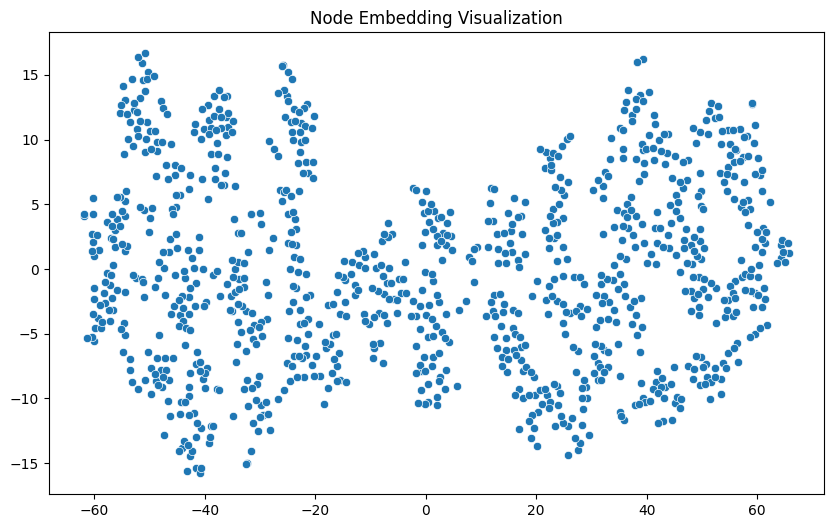

In [ ]:
# Recommendations
def recommend(user_idx, top_k=5):
    user_embedding = embeddings[user_idx]
    scores = torch.matmul(embeddings, user_embedding)
    recommended_items = torch.argsort(scores, descending=True)[:top_k]
    return recommended_items

# Visualize Embeddings
embeddings_np = embeddings.detach().numpy()
tsne_embeddings = TSNE(n_components=2).fit_transform(embeddings_np)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=tsne_embeddings[:, 0], y=tsne_embeddings[:, 1])
plt.title("Node Embedding Visualization")
plt.show()


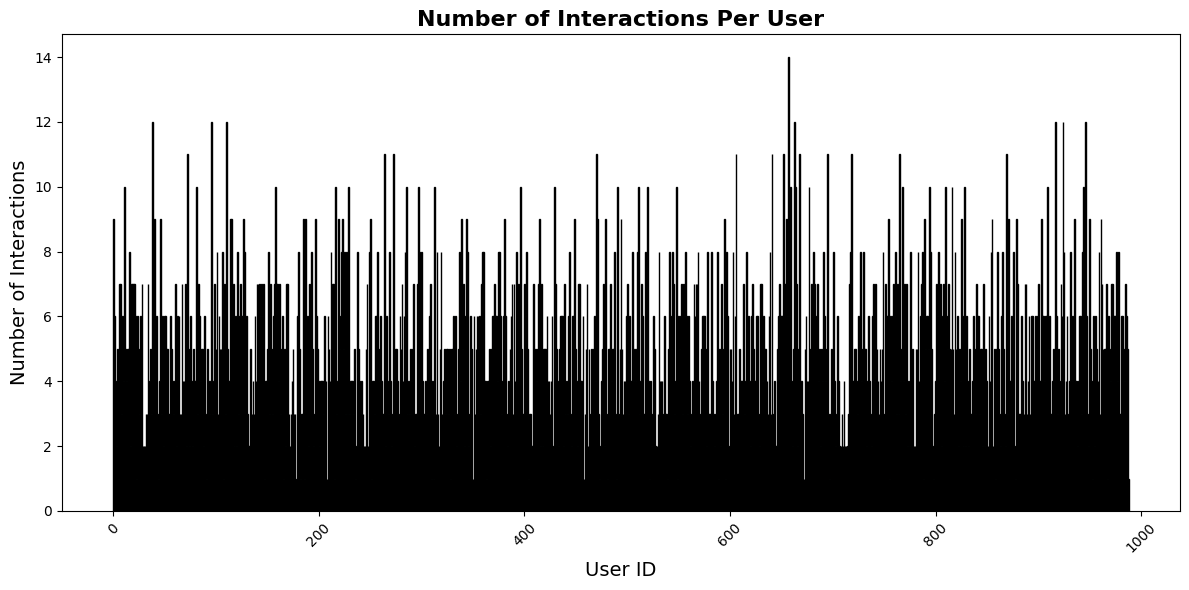

In [ ]:
import matplotlib.pyplot as plt

# Count the number of interactions per user
user_interactions = df['user_id'].value_counts()

# Plot the bar plot
plt.figure(figsize=(12, 6))
plt.bar(user_interactions.index, user_interactions.values, color='skyblue', edgecolor='blue')

# Add title and labels
plt.title("Number of Interactions Per User", fontsize=16, fontweight='bold')
plt.xlabel("User ID", fontsize=14)
plt.ylabel("Number of Interactions", fontsize=14)

# Customize ticks
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)

# Display the bar plot
plt.tight_layout()
plt.show()


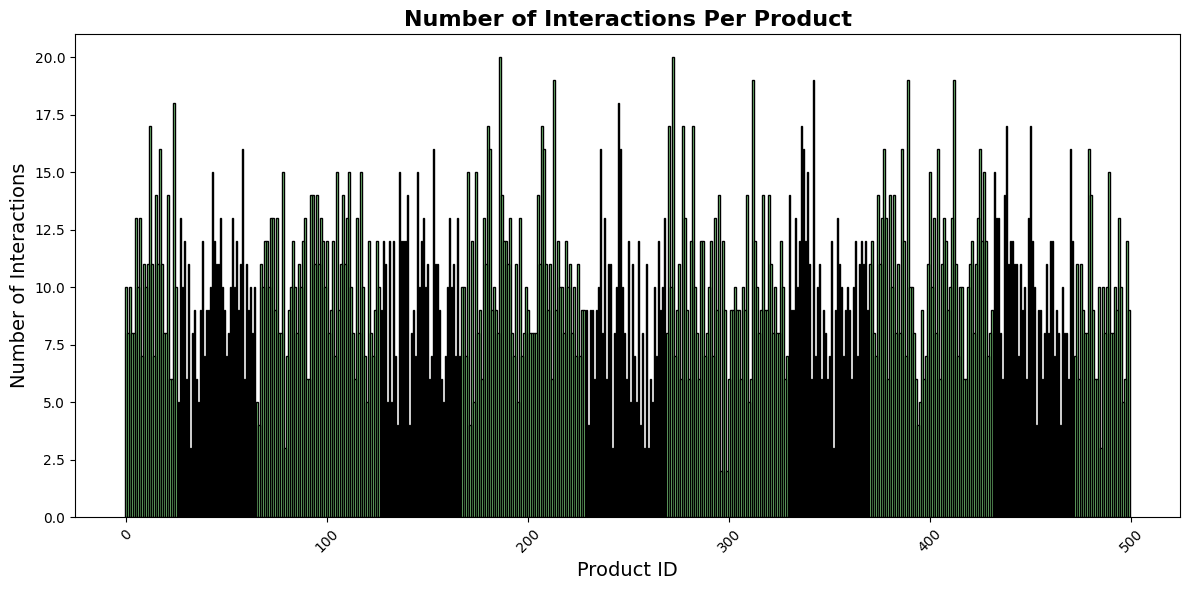

In [ ]:
# Count the number of interactions per product
product_interactions = df['product_id'].value_counts()

# Plot the bar plot
plt.figure(figsize=(12, 6))
plt.bar(product_interactions.index, product_interactions.values, color='lightgreen', edgecolor='black')

# Add title and labels
plt.title("Number of Interactions Per Product", fontsize=16, fontweight='bold')
plt.xlabel("Product ID", fontsize=14)
plt.ylabel("Number of Interactions", fontsize=14)

# Customize ticks
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)

# Display the bar plot
plt.tight_layout()
plt.show()


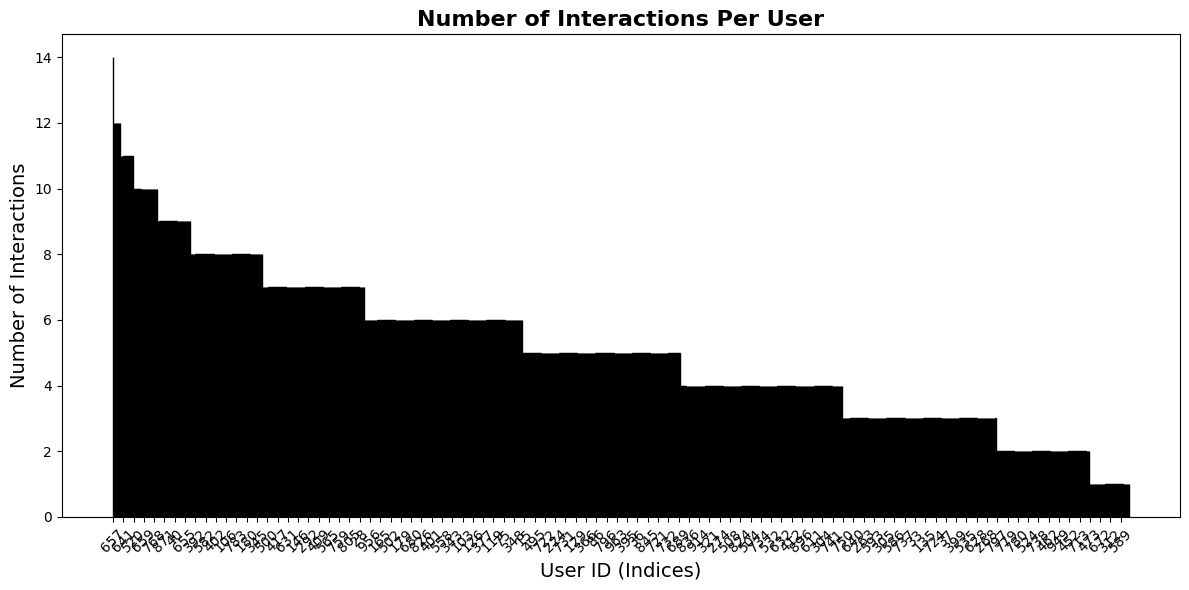

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Count the number of interactions per user
user_interactions = df['user_id'].value_counts()

# Create bar positions with spacing
bar_positions = np.arange(len(user_interactions))

# Plot the bar plot with spacing
plt.figure(figsize=(12, 6))
plt.bar(bar_positions, user_interactions.values, color='skyblue', edgecolor='black', width=0.5)

# Add title and labels
plt.title("Number of Interactions Per User", fontsize=16, fontweight='bold')
plt.xlabel("User ID (Indices)", fontsize=14)
plt.ylabel("Number of Interactions", fontsize=14)

# Adjust x-axis ticks and labels
plt.xticks(bar_positions[::10], user_interactions.index[::10], rotation=45, fontsize=10)
plt.yticks(fontsize=10)

# Display the bar plot
plt.tight_layout()
plt.show()


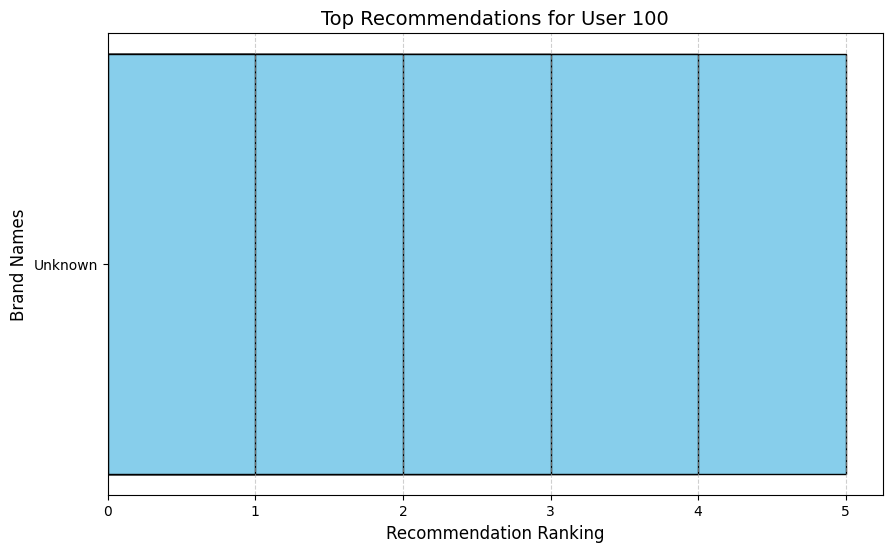

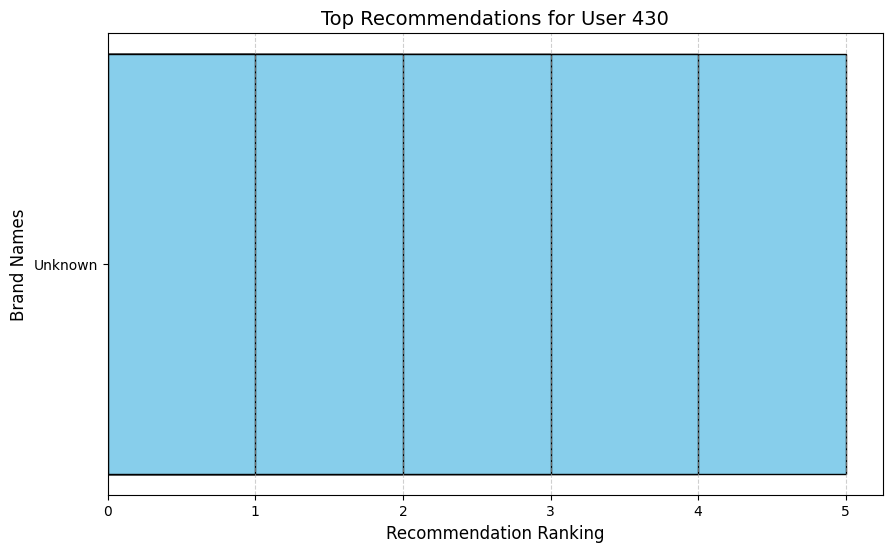

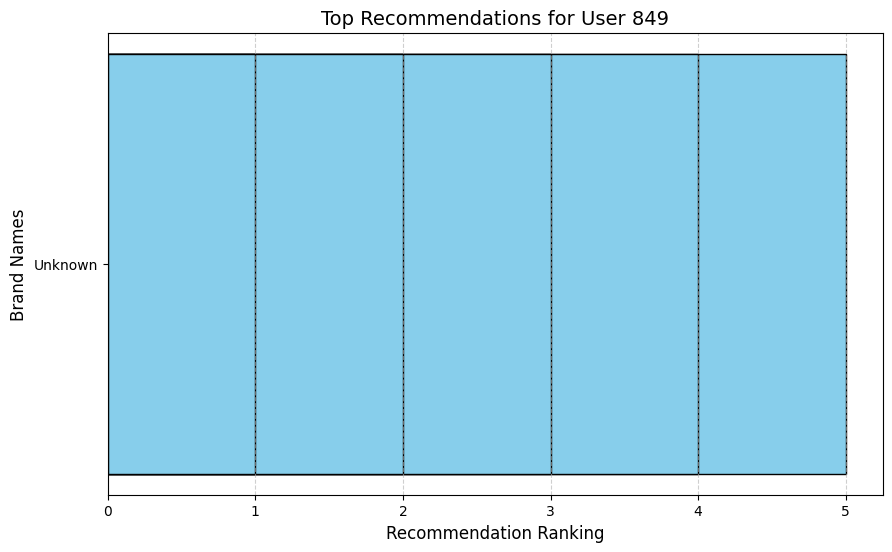

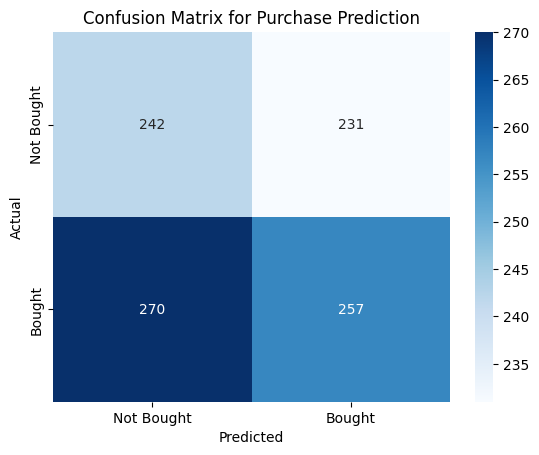

              precision    recall  f1-score   support

           0       0.47      0.51      0.49       473
           1       0.53      0.49      0.51       527

    accuracy                           0.50      1000
   macro avg       0.50      0.50      0.50      1000
weighted avg       0.50      0.50      0.50      1000

Recommended products for User 0: ['Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown']


In [ ]:
!pip install scikit-surprise

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy
from sklearn.metrics import confusion_matrix, classification_report

# 🔹 Step 1: Load Data
df = pd.read_excel('enhanced_ecommerce.xlsx')

# 🔹 Step 2: Encode Product_ID and User_ID
product_encoder = LabelEncoder()
user_encoder = LabelEncoder()

df['Product_ID'] = product_encoder.fit_transform(df['Product_ID'])
df['User_ID'] = user_encoder.fit_transform(df['User_ID'])

# Create a mapping from Product_ID to Brand_Name
product_to_brand_map = df.set_index('Product_ID')['Brand_Name'].to_dict()

# If 'Purchased' column exists, use it; otherwise, create a binary column (1 = bought, 0 = not bought)
if 'Purchased' not in df.columns:
    df['Purchased'] = np.random.choice([0, 1], size=len(df))  # Simulated binary purchase interactions

# 🔹 Step 3: Load Data into Surprise Library Format
reader = Reader(rating_scale=(0, 1))
data = Dataset.load_from_df(df[['User_ID', 'Product_ID', 'Purchased']], reader)

# 🔹 Step 4: Train-Test Split
trainset, testset = train_test_split(data, test_size=0.2)

# 🔹 Step 5: Train SVD Model for Matrix Factorization
model = SVD(n_factors=50, random_state=42)
model.fit(trainset)

# 🔹 Step 6: Generate Recommendations using Matrix Factorization
def generate_recommendations(model, user_id, top_n=5):
    """Recommend top N products for a given user using SVD Matrix Factorization"""
    all_products = df['Product_ID'].unique()
    scores = {prod: model.predict(user_id, prod).est for prod in all_products}

    # Get top N recommended products
    top_products = sorted(scores, key=scores.get, reverse=True)[:top_n]

    # Map indices to actual product names
    recommended_brands = [product_to_brand_map.get(product_encoder.inverse_transform([p])[0], "Unknown") for p in top_products]

    return recommended_brands

# 🔹 Step 7: Visualize Recommendations
def visualize_recommendations(num_users=3):
    selected_users = df['User_ID'].unique()[:num_users]

    for user_id in selected_users:
        products = generate_recommendations(model, user_id)

        # Create bar plot
        plt.figure(figsize=(10, 6))
        bars = plt.barh(products, range(len(products), 0, -1), color='skyblue', edgecolor='black')

        plt.xlabel("Recommendation Ranking", fontsize=12)
        plt.ylabel("Brand Names", fontsize=12)
        plt.title(f"Top Recommendations for User {user_id}", fontsize=14)
        plt.gca().invert_yaxis()
        plt.grid(axis='x', linestyle='--', alpha=0.6)
        plt.show()

# 🔹 Step 8: Evaluate Model using a Confusion Matrix
def evaluate_model():
    y_true = [int(truth[2]) for truth in testset]  # Actual purchases
    y_pred = [1 if model.predict(truth[0], truth[1]).est > 0.5 else 0 for truth in testset]  # Predicted purchases

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Bought", "Bought"], yticklabels=["Not Bought", "Bought"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix for Purchase Prediction")
    plt.show()

    # Print Classification Report
    print(classification_report(y_true, y_pred))

# 🔹 Step 9: Run Everything
visualize_recommendations(num_users=3)
evaluate_model()

# Example: Get Recommendations for User 0
user_id = 0
recommended_products = generate_recommendations(model, user_id)
print(f"Recommended products for User {user_id}: {recommended_products}")




/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


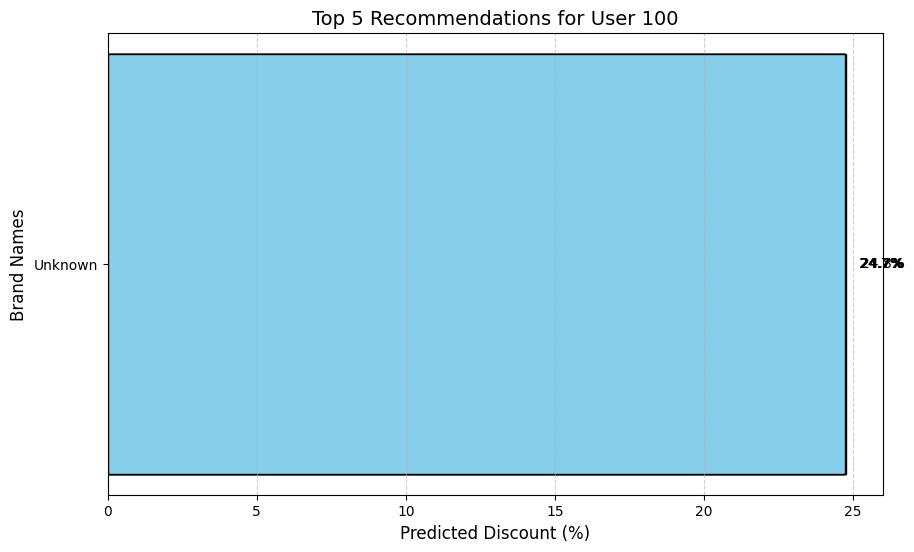

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


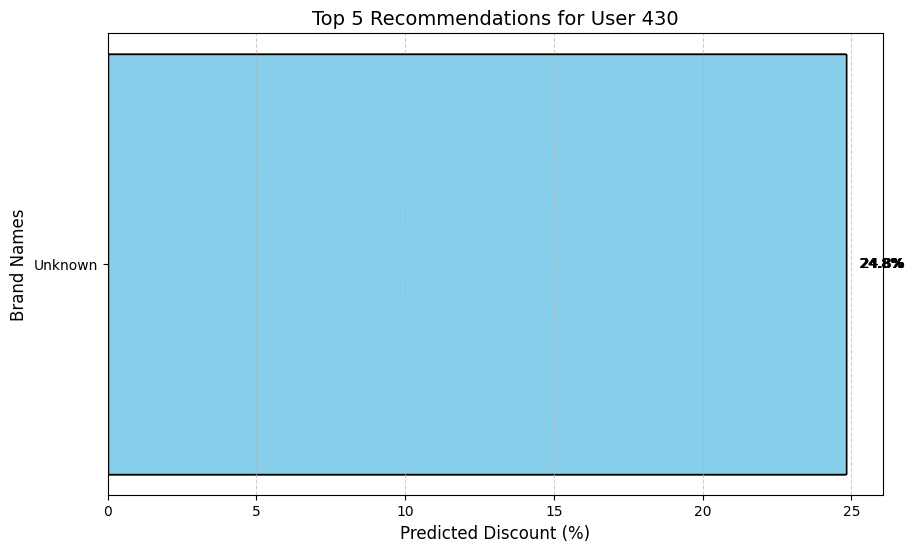

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


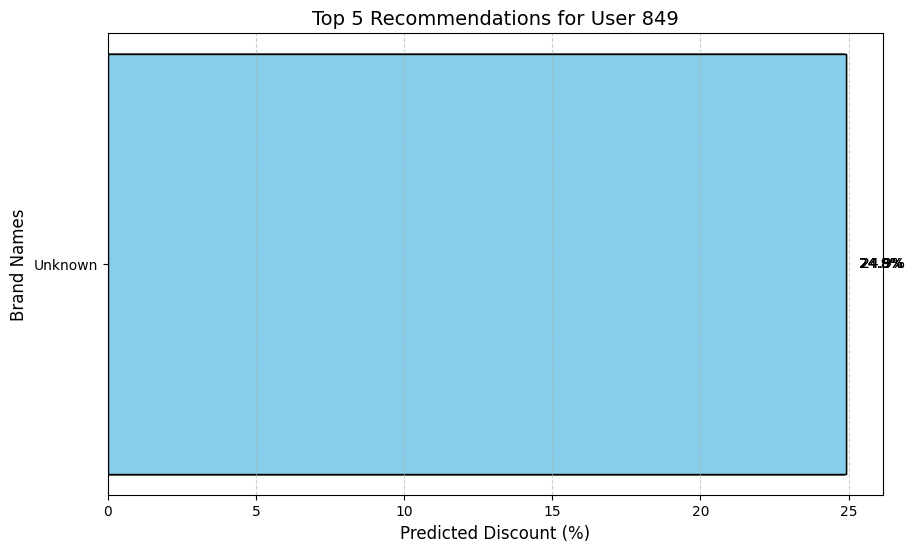

AttributeError: 'tuple' object has no attribute 'r_ui'

In [ ]:

!pip install scikit-surprise
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LinearRegression

# 🔹 Step 1: Load and Preprocess Data
df = pd.read_excel('enhanced_ecommerce.xlsx')
# 🔹 Step 2: Encode Product_ID and User_ID
product_encoder = LabelEncoder()
user_encoder = LabelEncoder()

df['Product_ID'] = product_encoder.fit_transform(df['Product_ID'])
df['User_ID'] = user_encoder.fit_transform(df['User_ID'])

# Create mapping from Product_ID to Brand_Name
product_to_brand_map = df.set_index('Product_ID')['Brand_Name'].to_dict()

# If 'Purchased' column exists, use it; otherwise, simulate binary purchase (1 = bought, 0 = not bought)
if 'Purchased' not in df.columns:
    df['Purchased'] = np.random.choice([0, 1], size=len(df))  # Simulated binary interactions

# 🔹 Step 3: Load Data into Surprise Library Format
reader = Reader(rating_scale=(0, 1))
data = Dataset.load_from_df(df[['User_ID', 'Product_ID', 'Purchased']], reader)

# 🔹 Step 4: Train-Test Split
trainset, testset = train_test_split(data, test_size=0.2)

# 🔹 Step 5: Train SVD Model for Recommendation
model = SVD(n_factors=50, random_state=42)
model.fit(trainset)

# 🔹 Step 6: Train Regression Model to Predict Discounts
if 'Discount' not in df.columns:
    df['Discount'] = np.random.rand(len(df)) * 50  # Simulate discount % if not in dataset

discount_model = LinearRegression()
discount_model.fit(df[['User_ID', 'Product_ID']], df['Discount'])  # Predict discounts based on user-product

# 🔹 Step 7: Generate Recommendations & Best Discounts
def recommend_products(user_id, top_n=5):
    """Recommend top N products and predicted discounts for a given user"""
    all_products = df['Product_ID'].unique()
    scores = {prod: model.predict(user_id, prod).est for prod in all_products}

    # Get top N products
    top_products = sorted(scores, key=scores.get, reverse=True)[:top_n]

    # Predict discount for each recommended product
    best_discounts = discount_model.predict(np.array([[user_id, p] for p in top_products]))

    # Map to brand names
    recommended_brands = [product_to_brand_map.get(product_encoder.inverse_transform([p])[0], "Unknown") for p in top_products]

    return recommended_brands, best_discounts

# 🔹 Step 8: Visualize Recommendations for a Few Users
def visualize_recommendations(num_users=3):
    selected_users = df['User_ID'].unique()[:num_users]

    for user_id in selected_users:
        products, discounts = recommend_products(user_id)

        # Plot recommendations
        plt.figure(figsize=(10, 6))
        bars = plt.barh(products, discounts, color='skyblue', edgecolor='black')

        # Annotate bars
        for bar, discount in zip(bars, discounts):
            plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, f"{discount:.1f}%", va='center', fontsize=10)

        plt.xlabel("Predicted Discount (%)", fontsize=12)
        plt.ylabel("Brand Names", fontsize=12)
        plt.title(f"Top {len(products)} Recommendations for User {user_id}", fontsize=14)
        plt.gca().invert_yaxis()
        plt.grid(axis='x', linestyle='--', alpha=0.6)
        plt.show()

# 🔹 Step 9: Evaluate with a Confusion Matrix
def evaluate_model():
    y_true = [int(truth.r_ui) for truth in testset]  # Actual purchases
    y_pred = [1 if model.predict(truth.uid, truth.iid).est > 0.5 else 0 for truth in testset]  # Predicted purchases

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Bought", "Bought"], yticklabels=["Not Bought", "Bought"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix for Purchase Prediction")
    plt.show()

    # Print Classification Report
    print(classification_report(y_true, y_pred))

# 🔹 Step 10: Run Everything
visualize_recommendations(num_users=3)
evaluate_model()

# Example: Get Recommendations for User 0
user_id = 0
recommended_products, best_discounts = recommend_products(user_id)
print(f"Recommended products for User {user_id}: {recommended_products}")
print(f"Predicted discounts: {best_discounts}")



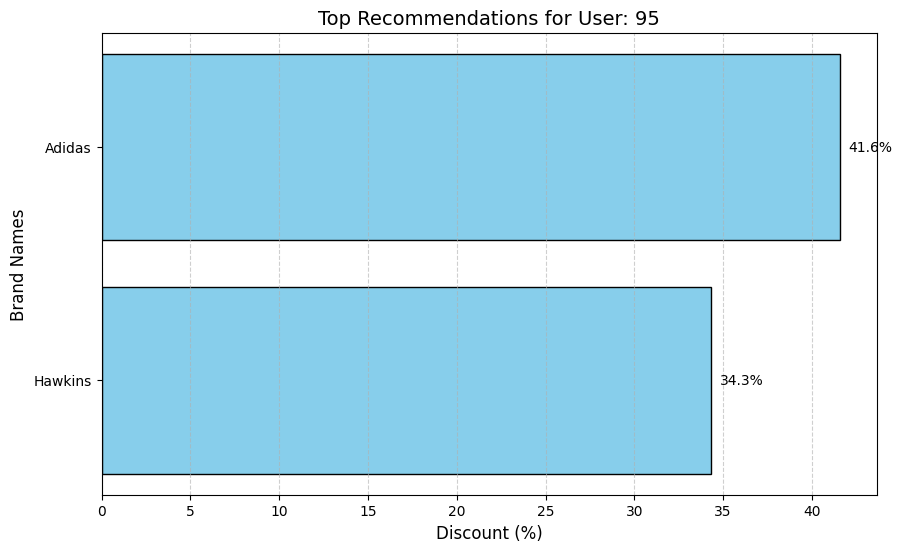

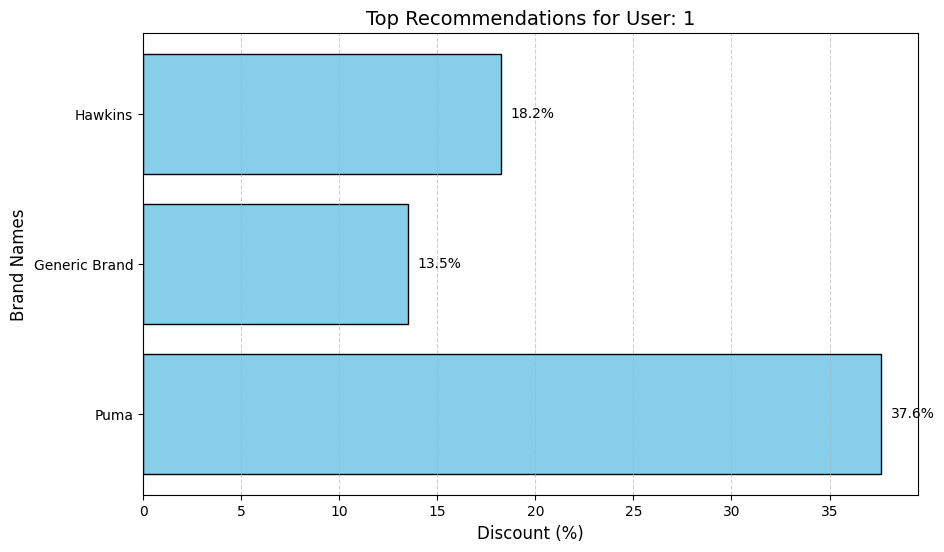

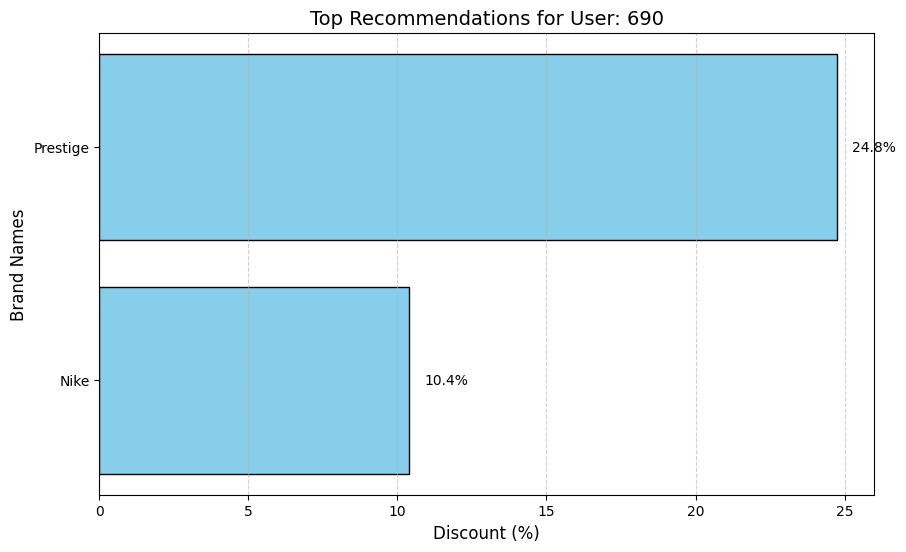

True Ratings Target Type: multiclass
Predicted Ratings Target Type: binary


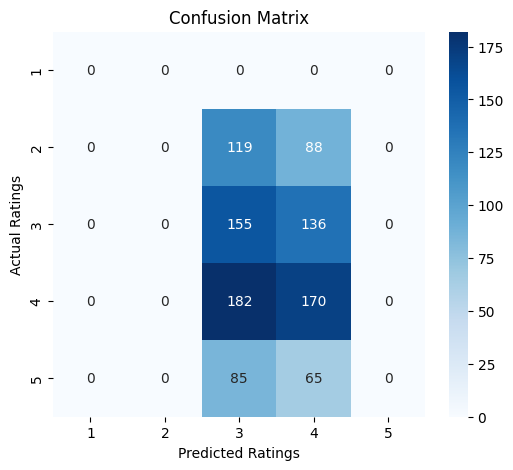

Model saved as 'svd_model.pkl'


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pickle

# Load data
df = pd.read_excel('enhanced_ecommerce.xlsx')

# Encode User_ID and Product_ID
user_encoder = {id_: idx for idx, id_ in enumerate(df["User_ID"].unique())}
product_encoder = {id_: idx for idx, id_ in enumerate(df["Product_ID"].unique())}
df["User_ID"] = df["User_ID"].map(user_encoder)
df["Product_ID"] = df["Product_ID"].map(product_encoder)

# Map Product_ID to Brand_Name
product_to_brand_map = df.set_index("Product_ID")["Brand_Name"].to_dict()

# Prepare Data for Surprise Library
reader = Reader(rating_scale=(1, 5))  # Assuming ratings are between 1 and 5
data = Dataset.load_from_df(df[["User_ID", "Product_ID", "Rating"]], reader)

# Split into train and test sets
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Train an SVD model
model = SVD(n_factors=50, random_state=42)
model.fit(trainset)

# Generate Predictions on Test Set
predictions = model.test(testset)

# Convert Predictions to Dictionary Format
recommendations = {}
for pred in predictions:
    user, product, true_rating, predicted_rating, _ = pred
    if user not in recommendations:
        recommendations[user] = []
    recommendations[user].append((product, predicted_rating))

# Assign Discounts Based on Prediction Scores
discount_matrix = np.random.uniform(10, 50, size=(len(user_encoder), len(product_encoder)))

final_recommendations = {}
for user in recommendations.keys():
    # Sort products by predicted rating (highest first)
    top_products = sorted(recommendations[user], key=lambda x: x[1], reverse=True)[:5]

    # Extract Product Names and Discounts
    recommended_product_names = [product_to_brand_map[prod] for prod, _ in top_products]
    discount_values = [discount_matrix[user, prod] for prod, _ in top_products]

    final_recommendations[user] = {
        "Recommended Products": recommended_product_names,
        "Discounts": discount_values
    }

# Visualize Recommendations
def visualize_recommendations(recommendations, num_users=3):
    selected_users = list(recommendations.keys())[:num_users]

    for user_id in selected_users:
        products = recommendations[user_id]["Recommended Products"]
        discounts = recommendations[user_id]["Discounts"]

        plt.figure(figsize=(10, 6))
        bars = plt.barh(products, discounts, color="skyblue", edgecolor="black")

        for bar, discount in zip(bars, discounts):
            plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height() / 2,
                     f"{discount:.1f}%", va="center", fontsize=10)

        plt.xlabel("Discount (%)", fontsize=12)
        plt.ylabel("Brand Names", fontsize=12)
        plt.title(f"Top Recommendations for User: {user_id}", fontsize=14)
        plt.gca().invert_yaxis()
        plt.grid(axis="x", linestyle="--", alpha=0.6)
        plt.show()

# Show Recommendations for 3 Users
visualize_recommendations(final_recommendations, num_users=3)

# Generate Confusion Matrix
from sklearn.utils.multiclass import type_of_target

true_ratings = np.array([int(round(pred.r_ui)) for pred in predictions])  # Ensure integer labels
predicted_ratings = np.array([int(round(pred.est)) for pred in predictions])

# Check target type
print("True Ratings Target Type:", type_of_target(true_ratings))
print("Predicted Ratings Target Type:", type_of_target(predicted_ratings))

# Generate Confusion Matrix
conf_matrix = confusion_matrix(true_ratings, predicted_ratings, labels=[1, 2, 3, 4, 5])
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
plt.xlabel("Predicted Ratings")
plt.ylabel("Actual Ratings")
plt.title("Confusion Matrix")
plt.show()


# Save the trained SVD model
with open("svd_model.pkl", "wb") as f:
    pickle.dump(model, f)

print("Model saved as 'svd_model.pkl'")


In [ ]:
from google.colab import files
files.download("svd_model.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>